# Pomegranate library

[`pomegranate` is a Python package](https://pomegranate.readthedocs.io/en/latest/index.html) that implements fast and flexible probabilistic models ranging from individual probability distributions to compositional models such as [Bayesian networks](https://en.wikipedia.org/wiki/Bayesian_network) and [Hidden Markov models](https://en.wikipedia.org/wiki/Hidden_Markov_model). 

The core philosophy behind pomegranate is that **all probabilistic models can be viewed as a probability distribution in that they all yield probability estimates for samples and can be updated given samples and their associated weights**. The primary consequence of this view is that the components that are implemented in pomegranate can be stacked more flexibly than other packages.

In [1]:
from pomegranate import *
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

---

## Probability distributions

### Initialization

In [2]:
n1 = NormalDistribution(5, 2)

### Random samples

In [3]:
n1.sample(10)

array([ 4.63182744,  6.36621905,  1.79253477,  2.47307143,  4.9550475 ,
       12.03512287,  1.45765111,  3.75971927,  5.63179653,  5.98264793])

### What's the probability of a sample data?

In [4]:
n1.probability(6)

0.17603266338221998

In [5]:
n1.log_probability(6)

-1.737085713764219

In [6]:
n1.probability([5,6,0,-2])

array([0.19947114, 0.17603266, 0.00876415, 0.00043634])

### Fitting with an array

In [7]:
n1.parameters

[5.0, 2.0]

In [8]:
a = np.random.normal(3.5,2.0,1000)+np.random.random(1000)

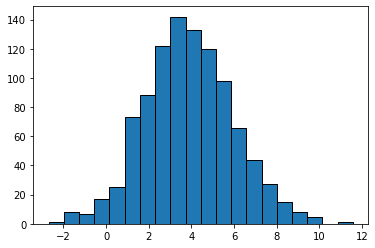

In [9]:
plt.hist(a,bins=20, edgecolor='k')
plt.show()

In [10]:
n1.fit(a)

In [11]:
n1.parameters

[3.8909056080889504, 2.0772587381572114]

### Creating the distribution from the sample data directly

In [12]:
n2 = NormalDistribution.from_samples(a)

In [13]:
print(n2)

{
    "class" : "Distribution",
    "name" : "NormalDistribution",
    "parameters" : [
        3.8909056080889504,
        2.0772587381572114
    ],
    "frozen" : false
}


### Plotting (histogram) is natively supported on the distribution class with the `plot()` method

In [14]:
beta = BetaDistribution(2,3)

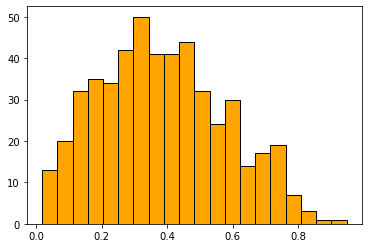

In [15]:
beta.plot(500,
          bins=20,
          edgecolor='k',
          color='orange')

### Discrete distribution

Instead of passing parameters as floats, you instead pass in a dictionary where keys can be any objects and values are the probability of them occurring.

In [16]:
discrete = DiscreteDistribution({'Harry':0.25, 'Ron':0.2, 'Hermione':0.35, 'Draco':0.2})

In [17]:
discrete.probability('Harry')

0.25

In [18]:
discrete.probability('Hagrid')

0.0

In [19]:
discrete.sample(10)

array(['Ron', 'Draco', 'Ron', 'Ron', 'Draco', 'Hermione', 'Draco',
       'Draco', 'Harry', 'Hermione'], dtype='<U8')

### Fitting a discrete distribution is easy

In [20]:
# A DNA sequence
dna_data = 'ACGATACACTGAATGACAGCAGTCACTGACAGTAGTACGAGTAGTAGCAGAGAGTAATAAAGAATTAATATATGACACTACGAAAAAAATGCATCG'
dna = list(dna_data)
# Starting with a equi-probability distribution of the 4 nucleic acids
d = DiscreteDistribution({'A':0.25,'T':0.25,'G':0.25,'C':0.25})

In [21]:
d.fit(dna)

In [22]:
print ("From the given DNA sequence, the probabilities are", d.parameters)

From the given DNA sequence, the probabilities are [{'A': 0.4375, 'T': 0.19791666666666666, 'G': 0.20833333333333334, 'C': 0.15625}]


### A simple DNA sequence matching application

In [23]:
dna_params = np.array(list(d.parameters[0].values()))
dna_params

array([0.4375    , 0.19791667, 0.20833333, 0.15625   ])

In [24]:
def gen_seq(length=100):
    from random import choices
    seq = ''.join(choices(['A','T','G','C'],k=length))
    return seq

In [25]:
dna_seq = []
for _ in range(5):
    dna_seq.append(gen_seq(96))

In [26]:
least = 99
least_idx = 0
for i in range(3):
    s = DiscreteDistribution({'A':0.25,'T':0.25,'G':0.25,'C':0.25})
    s.fit(dna_seq[i])
    sample_params = np.array(list(s.parameters[0].values()))
    distance = np.sqrt(np.sum((dna_params-sample_params)**2))
    if distance < least:
        least = distance
        least_idx = i
    print(f"The mean-square distance (of nucleic acid proportions) between\n {dna_data}\n and\n {dna_seq[i]}\n is {round(distance,4)}")
    print("-"*100)
    
print(f"The minimum distance was found for the sequence number {least_idx+1}")

The mean-square distance (of nucleic acid proportions) between
 ACGATACACTGAATGACAGCAGTCACTGACAGTAGTACGAGTAGTAGCAGAGAGTAATAAAGAATTAATATATGACACTACGAAAAAAATGCATCG
 and
 GCGAAGGCCGACGCCGACCTCCTCTGACTGTCGACCGTGGTAGGTGATTGCTGCTTCGGCATTTTCCATAGGCTATACGTTGCAGGCCCGCGCAGG
 is 0.335
----------------------------------------------------------------------------------------------------
The mean-square distance (of nucleic acid proportions) between
 ACGATACACTGAATGACAGCAGTCACTGACAGTAGTACGAGTAGTAGCAGAGAGTAATAAAGAATTAATATATGACACTACGAAAAAAATGCATCG
 and
 CTGAGGCATCAGAACACAGCATATGGGCTGACAGACAGGCGTATGACCCCGGATGAGATCGTTCTAGGCATACTCGTCCCACACTGCACCCATTGC
 is 0.2334
----------------------------------------------------------------------------------------------------
The mean-square distance (of nucleic acid proportions) between
 ACGATACACTGAATGACAGCAGTCACTGACAGTAGTACGAGTAGTAGCAGAGAGTAATAAAGAATTAATATATGACACTACGAAAAAAATGCATCG
 and
 TAAAGCTTTAGAAGATGTCGCACCCTGTGCTAAAGCTTCGGCTGCCAGTTCAAGTACTAGATGAAACCTGATTATAAGCCAC

---

## Gaussian Mixture Models

### Data

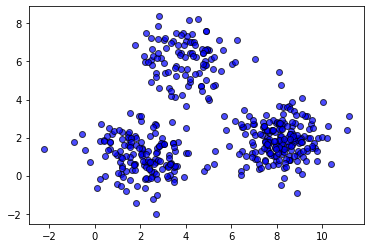

In [27]:
X = numpy.concatenate([numpy.random.normal((8, 2), 1, size=(200, 2)),
                       numpy.random.normal((2, 1), 1, size=(150, 2)),
                       numpy.random.normal((4, 6), 1, size=(100, 2))])

plt.scatter(X[:,0], X[:,1], color='blue',alpha=0.7,edgecolor='k')
plt.show()

### Model directly from the data

In [28]:
gmm = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, 3, X)

In [29]:
for d in gmm.distributions:
    print(d.parameters[0])

[8.162352837131197, 1.8863014822295276]
[4.0166748117763404, 6.101161649975762]
[2.088473252570433, 1.0100230642239891]


### Probability densities

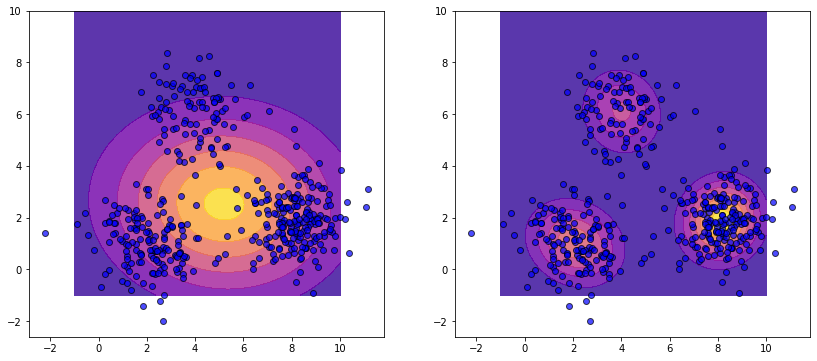

In [30]:
x = numpy.arange(-1, 10.1, .1)
y = numpy.arange(-1, 10.1, .1)

xx, yy = numpy.meshgrid(x, y)
x_ = numpy.array(list(zip(xx.flatten(), yy.flatten())))

p1 = MultivariateGaussianDistribution.from_samples(X).probability(x_).reshape(len(x), len(y))
p2 = gmm.probability(x_).reshape(len(x), len(y))


plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.contourf(xx, yy, p1, cmap='plasma', alpha=0.8)
plt.scatter(X[:,0], X[:,1],color='blue',alpha=0.7,edgecolor='k')

plt.subplot(122)
plt.contourf(xx, yy, p2, cmap='plasma', alpha=0.8)
plt.scatter(X[:,0], X[:,1],color='blue',alpha=0.7,edgecolor='k')
plt.show()

## Markov chain

In [31]:
transition_table = [['Rainy', 'Sunny', 0.10],
                                ['Rainy', 'Cloudy', 0.70],
                                ['Rainy', 'Rainy', 0.20],
                                ['Sunny', 'Sunny', 0.40],
                                ['Sunny', 'Cloudy', 0.40],
                                ['Sunny', 'Rainy', 0.20],
                                ['Cloudy', 'Cloudy', 0.40],
                                ['Cloudy', 'Rainy', 0.30],
                                ['Cloudy', 'Sunny', 0.20]]

In [32]:
d1 = DiscreteDistribution({'Rainy': 0.20, 'Sunny': 0.50, 'Cloudy': 0.30})
d2 = ConditionalProbabilityTable(transition_table, [d1])

mc = MarkovChain([d1,d2])

In [33]:
from tabulate import tabulate

In [34]:
t=tabulate(transition_table)

In [35]:
print(t)

------  ------  ---
Rainy   Sunny   0.1
Rainy   Cloudy  0.7
Rainy   Rainy   0.2
Sunny   Sunny   0.4
Sunny   Cloudy  0.4
Sunny   Rainy   0.2
Cloudy  Cloudy  0.4
Cloudy  Rainy   0.3
Cloudy  Sunny   0.2
------  ------  ---


In [36]:
mc.log_probability(['Cloudy','Rainy','Cloudy'])

-2.7646205525906047

In [37]:
mc.log_probability(['Rainy','Sunny','Rainy','Sunny'])

-7.824046010856291

In [38]:
print(mc.distributions[1])

Rainy	Sunny	0.10000000000000002
Rainy	Cloudy	0.7
Rainy	Rainy	0.2
Sunny	Sunny	0.4
Sunny	Cloudy	0.4
Sunny	Rainy	0.2
Cloudy	Cloudy	0.4
Cloudy	Rainy	0.3
Cloudy	Sunny	0.2


In [52]:
def gen_days(length=100):
    from random import choices
    seq = '-'.join(choices(['Sunny','Rainy','Cloudy'],k=length))
    return seq

In [55]:
mc_data = []
for _ in range(1):
    a = gen_days(14)
    print(a)
    b = a.split('-')
    mc_data.append(b)

Rainy-Sunny-Rainy-Sunny-Rainy-Sunny-Rainy-Rainy-Sunny-Sunny-Sunny-Rainy-Sunny-Cloudy


In [56]:
mc.fit(mc_data)

In [57]:
print(mc.distributions[1])

Rainy	Sunny	0.8333333333333334
Rainy	Cloudy	0.0
Rainy	Rainy	0.16666666666666669
Sunny	Sunny	0.2857142857142857
Sunny	Cloudy	0.14285714285714285
Sunny	Rainy	0.5714285714285714
Cloudy	Cloudy	0.3333333333333333
Cloudy	Rainy	0.3333333333333333
Cloudy	Sunny	0.3333333333333333


In [58]:
mc_data = []
for _ in range(1):
    a = gen_days(3650)
    b = a.split('-')
    mc_data.append(b)

In [59]:
mc.fit(mc_data)
print(mc.distributions[1])

Rainy	Sunny	0.3196457326892109
Rainy	Cloudy	0.3260869565217391
Rainy	Rainy	0.3542673107890499
Sunny	Sunny	0.33075601374570446
Sunny	Cloudy	0.3393470790378007
Sunny	Rainy	0.32989690721649484
Cloudy	Cloudy	0.3563958165728078
Cloudy	Rainy	0.336283185840708
Cloudy	Sunny	0.3073209975864843


## Hidden Markov Model (HMM)

In [43]:
d1 = DiscreteDistribution({'Harry': 0.25, 'Ron': 0.25, 
                           'Hagrid': 0.25, 'Dumbledore': 0.25})
d2 = DiscreteDistribution({'Harry': 0.4, 'Ron': 0.10, 
                           'Hagrid': 0.1, 'Dumbledore': 0.4})

In [44]:
s1 = State(d1, name='uniform')
s2 = State(d2, name='Harry-Dumbledore')

In [45]:
hmm = HiddenMarkovModel()
hmm.add_states(s1, s2)

In [46]:
hmm.add_transition(hmm.start, s1, 0.5)
hmm.add_transition(hmm.start, s2, 0.5)
hmm.add_transition(s1, s1, 0.9)
hmm.add_transition(s1, s2, 0.1)
hmm.add_transition(s2, s1, 0.1)
hmm.add_transition(s2, s2, 0.9)

In [47]:
hmm.bake()

In [48]:
seq = 'Harry-Hagrid-Ron-Hagrid-Ron-Harry-\
Dumbledore-Harry-Dumbledore-Ron-\
Harry-Dumbledore-Hagrid-Dumbledore-Harry-\
Ron-Hagrid-Hagrid-Harry-\
Dumbledore-Hagrid-Harry-Dumbledore-Harry-\
Dumbledore-Ron-Dumbledore-Hagrid'

In [49]:
seq = list(seq.split('-'))

In [50]:
hmm_predictions = hmm.predict(seq)

In [51]:
print(hmm_predictions)

[1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1]
